## Make a feature-centric eddy composite, v4
##### New updates from v3: add vertical component for 3-D vars in eddy composites, testing for Dec 31, add vertical plots

In [1]:
import eddy_tracks
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate
import metpy.calc as mpcalc
import math

### Define some functions

In [2]:
def calc_distance(eddy,xlen,ylen,eddy_tracks):
    
    distances= np.empty([ylen, xlen])
    
    #Haversine formula, assumes Earth is a sphere
    R = 6373.0 #radius of earth (km)

    lat1 = eddy_tracks.y.iloc[eddy]
    lon1 = eddy_tracks.x.iloc[eddy]

    lat2 = ds.TLAT
    lon2 = ds.TLONG

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = (np.sin(dlat / 2) * np.sin(dlat / 2) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(dlon / 2) * np.sin(dlon / 2))

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = R * c
    return distances

In [3]:
def put_coords(databox):

        #first do lons
        start = -1*int(len(databox.lon)/2)
        if len(databox.lon)%2 == 0.:
            end=int(len(databox.lon)/2)
        else:
            end=int(len(databox.lon)/2 + 1)

        databox['lon']=np.arange(start,end,1)

        #now do lats
        start = -1*int(len(databox.lat)/2)

        if len(databox.lat)%2 == 0.:
            end=int(len(databox.lat)/2)
        else:
            end=int(len(databox.lat)/2 + 1)

        databox['lat']=np.arange(start,end,1) # databox = databox.assign_coords({'lat':np.arange(start,end,1)})

        return databox

In [4]:
def composite_a_2D_eddy(eddy_tracks, ds, var, n_reps, threshold_r):

    xlen=len(ds.nlon)
    ylen=len(ds.nlat)
    elen=len(eddy_tracks)
    
    #initialize sum
    sum_databoxes = 0
    count_eddies = 0

    for eddy in np.arange(0,elen,1):
        #print("starting eddy ", eddy)

        distance = calc_distance(eddy,xlen,ylen,eddy_tracks)

        #normalize distance to eddy radius
        distance_normrad = distance / eddy_tracks.radius_km.iloc[eddy]

        #extract just these values
        sorted_distances = np.sort(distance_normrad, axis=None)
        sorted_distances = sorted_distances[sorted_distances < threshold_r]
        limit_index=len(sorted_distances)

        #get the x,y indices of the qualifying gridcells
        indices = np.unravel_index(np.argsort(distance_normrad.data, axis=None), distance_normrad.shape)

        #make a subset based on the limit index for qualifying distances
        indices_subset = (indices[0][:limit_index],indices[1][:limit_index])

        #get the four indices for getting out hi res data in the box
        x_min, x_max=np.percentile(indices_subset[0], [0,100])
        y_min, y_max=np.percentile(indices_subset[1], [0,100])
        x_min = int(x_min)
        x_max = int(x_max)
        y_min = int(y_min)
        y_max = int(y_max)

        #extract data for the variable with these indices
        databox = var[x_min:x_max,y_min:y_max] # databox = var.isel(lon=slice(x_min,x_max+1), lat=slice(y_min,y_max+1))

        if np.isnan(databox).any() != True:

            count_eddies = count_eddies + 1

            #make databox an xr DataArray
            databox = xr.DataArray(databox,dims=('lat','lon'))

            databox_smooth = mpcalc.smooth_n_point(databox, 9, n_reps)
            databox_smooth = xr.DataArray(databox_smooth,dims=('lat','lon'))
            databox_smooth.attrs = databox.attrs

            #make it anomalies
            databox = databox - databox_smooth

            #put data in the coordinates so that the eddies can be overlaid with their centers aligned
            databox = put_coords(databox)

            #now make a running sum
            sum_databoxes = sum_databoxes + databox     

        else:
            print('skipping eddy number', eddy)

    #finally, out of the loop, divide by the eddy number so that we have mean
    composite = sum_databoxes / count_eddies
    
    return composite, count_eddies

In [5]:
def composite_a_3D_eddy(eddy_tracks, ds, var, n_reps, threshold_r):
    print('got a 3-d var')
    xlen=len(ds.nlon)
    ylen=len(ds.nlat)
    elen=len(eddy_tracks)

    #initialize sum
    sum_databoxes = 0
    count_eddies = 0

    ###########first see if there are eddies with nans

    eddy_list=[]
    eddies_dict = dict()


    if var.dims[0]=='z_t':
        z_dim = 'z_t'
    else:
        z_dim = 'z_t_150m'

    for eddy in np.arange(0,elen,1):
        #print(eddy)
        distance = calc_distance(eddy,xlen,ylen,eddy_tracks)

        #normalize distance to eddy radius
        distance_normrad = distance / eddy_tracks.radius_km.iloc[eddy]

        #extract just these values
        sorted_distances = np.sort(distance_normrad, axis=None)
        sorted_distances = sorted_distances[sorted_distances < threshold_r]
        limit_index=len(sorted_distances)

        #get the x,y indices of the qualifying gridcells
        indices = np.unravel_index(np.argsort(distance_normrad.data, axis=None), distance_normrad.shape)

        #make a subset based on the limit index for qualifying distances
        indices_subset = (indices[0][:limit_index],indices[1][:limit_index])

        #get the four indices for getting out hi res data in the box
        x_min, x_max=np.percentile(indices_subset[0], [0,100])
        y_min, y_max=np.percentile(indices_subset[1], [0,100])
        x_min = int(x_min)
        x_max = int(x_max)
        y_min = int(y_min)
        y_max = int(y_max)

        databox = var[0:15, x_min:x_max, y_min:y_max]

        #make databox an xr DataArray
        databox = xr.DataArray(databox,dims=(z_dim,'lat','lon'))

        if np.isnan(var[0:15,x_min:x_max,y_min:y_max]).any() != True:
            eddy_list.append(eddy)

            eddy_str = str(eddy)
            eddies_dict[eddy_str] = databox

            if count_eddies==0:
                width=len(databox.lon)
                height=len(databox.lat)
            else:
                width=(min(width, len(databox.lon)))
                height=(min(height, len(databox.lat)))
                
            count_eddies = count_eddies + 1

    sums3d = xr.DataArray(np.zeros([15,height,width]),dims=(z_dim,'lat','lon'))

    for z in np.arange(0,15,1):

        #print('doing depth',z)
        if z_dim=='z_t':
            var2d = var.isel(z_t=z).squeeze()
        else:
            var2d = var.isel(z_t_150m=z).squeeze()

        for eddy in eddy_list:

            eddy_str = str(eddy)

            databox = eddies_dict[eddy_str][z,:,:].squeeze()

            databox_smooth = mpcalc.smooth_n_point(databox, 9, n_reps)
            databox_smooth = xr.DataArray(databox_smooth,dims=('lat','lon'))
            databox_smooth.attrs = databox.attrs

            #make it anomalies
            databox = databox - databox_smooth

            #put data in the coordinates so that the eddies can be overlaid with their centers aligned
            databox = put_coords(databox)

            #now make a running sum
            sum_databoxes = sum_databoxes + databox 

        sums3d[z,:,:]=sum_databoxes
        count_eddies=len(eddy_list)

    composite = sums3d / count_eddies

    return composite, count_eddies

### get the tracks

In [6]:
pth = '/glade/p/cgd/oce/people/mclong/hi-res-eco/data/analysis/tracks_20161128'
file_in = f'{pth}/0_pt_1_CESM_tracks.mat'
tracks = pd.DataFrame(eddy_tracks.track_mat2py(file_in))
tracks = tracks.rename(columns={"Ls": "radius_km"})
tracks

,x,y,amp,area,u,age,radius_km,id,cyc,year,mon,day
0,242.258195,40.498931,2.994491,10809.049919,NaN,10.0,58.656862,1,1,1,1,5
1,242.600100,-69.344310,0.125429,1307.723710,NaN,10.0,20.402485,2,1,1,1,5
2,242.700100,-64.131685,3.458723,6708.039396,5.631560,10.0,46.208606,3,1,1,1,5
3,245.400100,-61.955224,13.669557,10985.213312,26.323848,10.0,59.132918,4,1,1,1,5
4,245.600100,-67.146695,0.551876,1666.310001,NaN,10.0,23.030479,5,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1599345,258.500100,-63.513617,6.218261,9476.326775,11.992946,125.0,54.921840,230803,-1,5,12,31
1599346,258.600100,-55.425356,2.878914,6293.522627,8.810720,35.0,44.758133,236814,-1,5,12,31
1599347,258.600100,-49.654134,0.655865,8606.090785,NaN,55.0,52.339314,235516,-1,5,12,31
1599348,258.800100,-21.714382,0.378134,8417.142072,NaN,20.0,51.761564,237872,-1,5,12,31


### make a dictionary of the hi-res days for each month

In [7]:
day_dict = {
        "jan" : (5,10,15,20,25,30),
        "feb" : (4,9,14,19,24),
        "mar" : (1,6,11,16,21,26,31),
        "apr" : (5,10,15,20,25,30),
        "may" : (5,10,15,20,25,30),
        "jun" : (4,9,14,19,24,29),
        "jul" : (4,9,14,19,24,29),
        "aug" : (3,8,13,18,23,28),
        "sep" : (2,7,12,17,22,27),
        "oct" : (2,7,12,17,22,27),
        "nov" : (1,6,11,16,21,26),
        "dec" : (1,6,11,16,21,26,31)
        }

In [8]:
days=[31] #just do the one day for testing

#### set variables, select tracks, make eddy composites

In [9]:
##################################################################### Step 1: sort the tracks
month=12 
month_name='dec'
variables = ['diatChl','PO4','TEMP','diat_N_lim','SSH','NO3'] ############### set here!!

lat_max=-30
lat_min=-40
lon_max=360
lon_min=0

n_reps = 20      # number of repetitions for 9 pt smoother of databox
threshold_r=4    #radius normalized distance threshold for including in composite

age_min=30     #eddy age in days
amp_min=1      #eddy amplitude in cm
year=5               

radius_min=55
radius_max=65

valid_eddies_cyc_sum=0
valid_eddies_anticyc_sum=0
counter=0
#for day in day_dict[month_name]:
for day in days:
    print(counter)
    #sort by age, amplitude, size, lon/lat range, and eddy type
    selected_eddies = tracks[(tracks.age >= age_min) & 
                             (tracks.amp >= amp_min) & 
                             (tracks.year == year) & 
                             (tracks.mon == month) &
                             (tracks.day == day) & 
                             (tracks.y < lat_max) &
                             (tracks.y > lat_min) &
                             (tracks.x < lon_max) &
                             (tracks.x > lon_min) &
                             (tracks.radius_km >= radius_min) &
                             (tracks.radius_km < radius_max)]

    eddy_type=-1    #anticyclonic = 1, cyclonic=-1
    selected_eddies_cyc = selected_eddies[(selected_eddies.cyc == eddy_type)]

    eddy_type=1    #anticyclonic = 1, cyclonic=-1
    selected_eddies_anticyc = selected_eddies[(selected_eddies.cyc == eddy_type)]

    ##################################################################### Step 2: get the corresponding gridded data
    case = 'g.e11.G.T62_t12.eco.006'
    y4 = "{:04d}".format(year)
    m2 = "{:02d}".format(month)
    d2 = "{:02d}".format(day)

    file = f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist/{case}.pop.h.{y4}-{m2}-{d2}.nc'
    ds = xr.open_dataset(file, decode_times=False, decode_coords=False)
    coords = {'x':'TLONG','y':'TLAT'}
    keep_vars = variables + list(coords.values())+['dz','KMT']
    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

    ###################################################################### Step 3: make composites
    ###### cyclonic
    composite_ds_cyc = xr.Dataset()

    for varname in variables:

        print('doing cyclonic',varname)
        var = ds[varname]
        var.attrs=([]) #getting rid of attributes because it messes up the metpy smoother

        if len(var.dims)>2: 
            composite, valid_eddies_cyc = composite_a_3D_eddy(selected_eddies_cyc, ds, var, n_reps, threshold_r)
        else:
            composite, valid_eddies_cyc = composite_a_2D_eddy(selected_eddies_cyc, ds, var, n_reps, threshold_r)
            
        composite_ds_cyc[varname] = composite

    ###### anticyclonic
    composite_ds_anticyc = xr.Dataset()

    for varname in variables:

        print(varname)
        var = ds[varname]
        var.attrs=([]) #getting rid of attributes because it messes up the metpy smoother

        if len(var.dims)>2: 
            composite, valid_eddies_anticyc = composite_a_3D_eddy(selected_eddies_anticyc, ds, var, n_reps, threshold_r)
        else:
            composite, valid_eddies_anticyc = composite_a_2D_eddy(selected_eddies_anticyc, ds, var, n_reps, threshold_r)
            
        composite_ds_anticyc[varname] = composite

    #do running sum of anomalies, weighting by the number of valid eddies
    valid_eddies_cyc_sum = valid_eddies_cyc_sum + valid_eddies_cyc
    valid_eddies_anticyc_sum = valid_eddies_anticyc_sum + valid_eddies_anticyc
    
    if counter == 0:
        all_cyc_comps = composite_ds_cyc * valid_eddies_cyc
        all_anticyc_comps = composite_ds_anticyc * valid_eddies_anticyc
    else:
        all_cyc_comps = all_cyc_comps + composite_ds_cyc * valid_eddies_cyc
        all_anticyc_comps = all_anticyc_comps + composite_ds_anticyc * valid_eddies_anticyc
    
    counter = counter + 1
    
    
#now divide by the sum of the weights 
all_cyc_comps = all_cyc_comps / valid_eddies_cyc_sum
all_anticyc_comps = all_anticyc_comps / valid_eddies_anticyc_sum

0
doing cyclonic diatChl
got a 3-d var
doing cyclonic PO4
got a 3-d var
doing cyclonic TEMP
got a 3-d var
doing cyclonic diat_N_lim
got a 3-d var
doing cyclonic SSH
skipping eddy number 13
doing cyclonic NO3
got a 3-d var
diatChl
got a 3-d var
PO4
got a 3-d var
TEMP
got a 3-d var
diat_N_lim
got a 3-d var
SSH
skipping eddy number 0
skipping eddy number 12
skipping eddy number 16
NO3
got a 3-d var


In [20]:
all_cyc_comps.lon

<xarray.DataArray 'lon' (lon: 45)>
array([-22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
        -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22])
Coordinates:
  * lon      (lon) int64 -22 -21 -20 -19 -18 -17 -16 ... 16 17 18 19 20 21 22

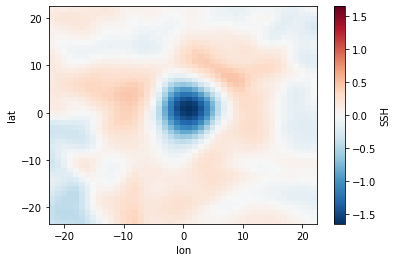

In [10]:
all_cyc_comps.SSH.plot()

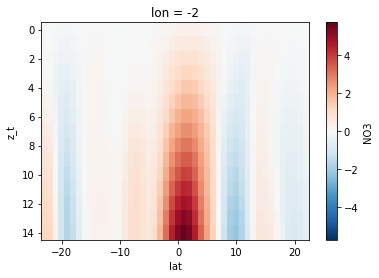

In [11]:
all_cyc_comps.NO3.isel(lon=20).plot(yincrease=False)

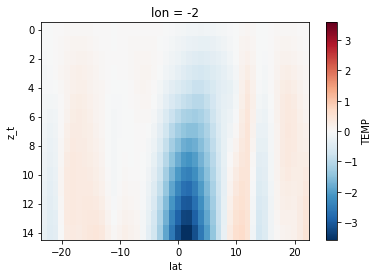

In [12]:
all_cyc_comps.TEMP.isel(lon=20).plot(yincrease=False)

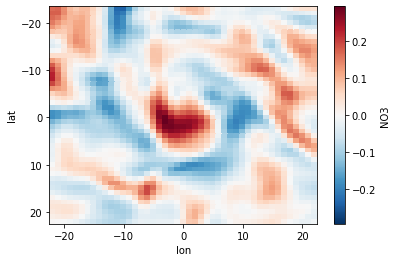

In [13]:
all_cyc_comps.NO3.isel(z_t=0).plot(yincrease=False)

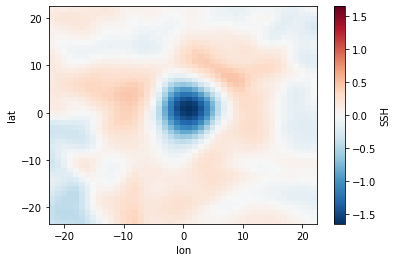

In [14]:
all_cyc_comps.SSH.plot()

### PLOT cyclonic eddy composites

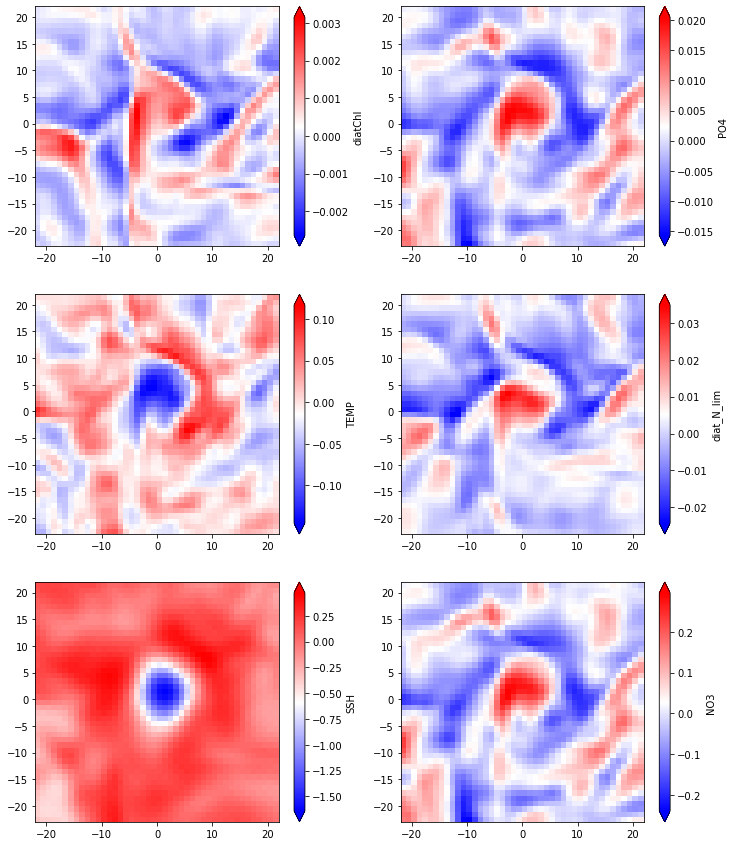

In [15]:
num_comp=len(variables)
fig_width = num_comp * 2
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    var= all_cyc_comps[varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    
    pc=ax.pcolormesh(all_cyc_comps.lon, all_cyc_comps.lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### PLOT anticyclonic eddy composites

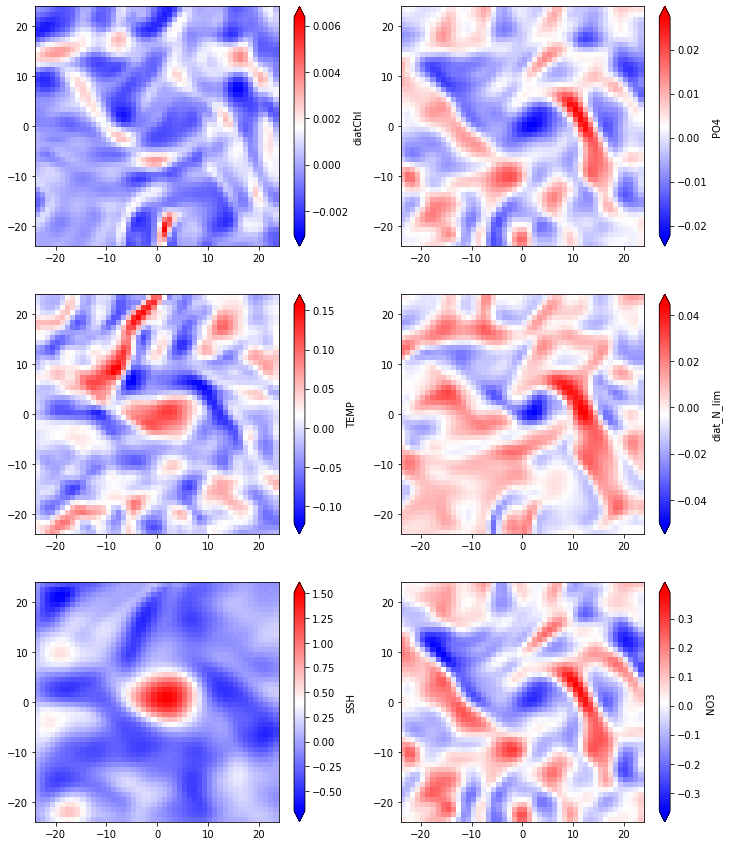

In [16]:
num_comp=len(variables)
fig_width = num_comp * 2
fig_height = (num_comp * 3) - 3
rows = math.ceil(num_comp/2)
cols = 2

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    ax = fig.add_subplot(rows,cols,count)
    var= all_anticyc_comps[varname]
    if len(var.dims)>2: 
        if var.dims[0]=='z_t':
            var=var.isel(z_t=0)
        else:
            var=var.isel(z_t_150m=0)
    
    pc=ax.pcolormesh(all_anticyc_comps.lon, all_anticyc_comps.lat, var, cmap='bwr')
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1

### Vertical section composites

#### Cyclonic on left, anticyclonic on right

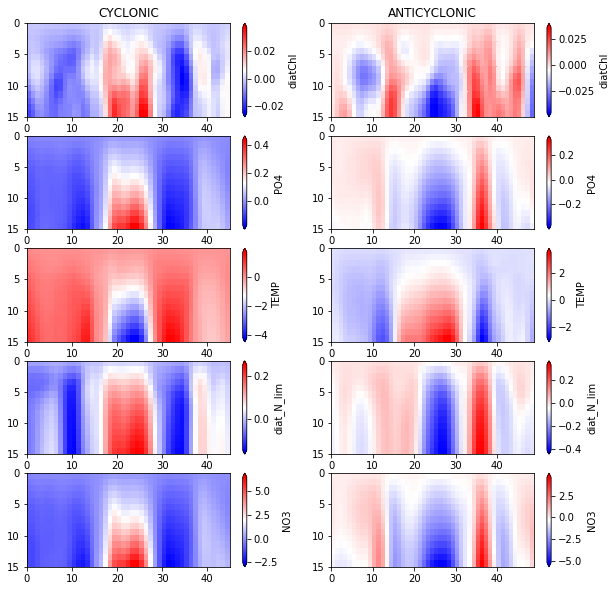

In [19]:
#list of 3d vars

variables=['diatChl','PO4','TEMP','diat_N_lim','NO3']

fig_width=10
fig_height=len(variables)*2
rows=len(variables)

fig = plt.figure(figsize=(fig_width,fig_height))
count = 1
for varname in variables:
    
    ##### cyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    if count==1:
        ax.set_title('CYCLONIC')
    var= all_cyc_comps[varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    
    ##### anticyclonic
    ax = fig.add_subplot(rows,cols,count)
    ax.invert_yaxis()
    if count==2:
        ax.set_title('ANTICYCLONIC')
    var= all_anticyc_comps[varname].sel(lat=0)

    pc=ax.pcolormesh(var, cmap='bwr')
    
    cbar = fig.colorbar(pc, label=varname,extend='both')
    count = count + 1
    